In [1]:
import numpy as np
from scipy import stats
import scipy.io
from matplotlib import pyplot as plt
import time
import pstats

In [33]:
def Gibbs_GCHMM(G, Ytrue, mask, T, 
                prior={'ap':2, 'bp':5, 'aa':2, 'ba':5, 'ab':2, 'bb':5, 'ar':2, 'br':5, 'a1':5, 'b1':2, 'a0':2, 'b0':5}):
    # Gibbs sampling for GCHMMs with inference and parameter estimation
    # G: non-symmetric social networks
    # Y: evidence, observed data
    # T: num. of iterations
    N, _, D = G.shape
    _, S, _ = Ytrue.shape
    
    ## Initialization
    X = np.zeros((N,D+1))
    R = np.zeros((N,D))
    #hyperparameters
    #hyperparameters
    ap = prior['ap']; bp = prior['bp']
    aa = prior['aa']; ba = prior['ba']
    ab = prior['ab']; bb = prior['bb']
    ar = prior['ar']; br = prior['br']
    a1 = prior['a1']; b1 = prior['b1']
    a0 = prior['a0']; b0 = prior['b0']
    
    xi = stats.beta.rvs(ap, bp, size=1)
    alpha = stats.beta.rvs(aa,ba,size=1)
    beta = stats.beta.rvs(ab,bb,size=1)
    gamma = stats.beta.rvs(ar,br,size=1)
    theta1 = stats.beta.rvs(a1,b1,size=(1,S)) 
    theta0 = stats.beta.rvs(a0,b0,size=(1,S)) 
    
    ##Iterative Sampling
    B = T/2 # Burn-in from Iteration B
    Xbi = X # Burn-in for X
    Ybi = np.zeros((Ytrue.shape))
    parabi = np.zeros((1,2*S+4)) # Burn-in for all parameters
    NPI = np.zeros((N,D)) # Num. of previous infection

    for t in range(T):
        th1 = np.repeat(np.repeat(theta1.reshape((1,S,1)), N, axis=0), D, axis=2)
        th0 = np.repeat(np.repeat(theta0.reshape((1,S,1)), N, axis=0), D, axis=2)
        Ym = mask * (stats.bernoulli.rvs(th1, size=Ytrue.shape) * (X[:,1:] == 1).reshape(N, 1 ,D) + 
                stats.bernoulli.rvs(th0, size=Ytrue.shape) * (X[:,1:] == 0).reshape(N, 1, D))
        Y = Ym + (1 - mask) * Ytrue

        # Update the initial X, root
        NPI[:,0] = NumPreInf(X[:,0],G[:,:,0]);
        p1 = xi*(gamma**np.array(X[:,1]==0)*(1-gamma)**np.array(X[:,1]))
        p0 = (1-xi)*(1-(1-alpha)*(1-beta)**NPI[:,0])**X[:,1]*((1-alpha)*(1-beta)**NPI[:,0])**(X[:,1]==0)
        p = p1 / (p0+p1)
        X[:,0] = 0+(np.random.rand(N,)<=p)
    
        # Update intermediate X
        for i in range(1,D):
            NPI[:,i-1] = NumPreInf(X[:,i-1],G[:,:,i-1])
            NPI[:,i] = NumPreInf(X[:,i],G[:,:,i])
            tmp1 = np.exp(Y[:,:,i-1] @ np.log(theta1.T))*np.exp((1-Y[:,:,i-1]) @ np.log(1-theta1.T))
            p1 = gamma**(X[:,i+1]==0)*(1-gamma)**(X[:,i-1]+X[:,i+1])*(1-(1-alpha)*(1-beta)**NPI[:,i-1])**(X[:,i-1]==0) * tmp1.reshape((N,))
            tmp0 = np.exp(Y[:,:,i-1] @ np.log(theta0.T))*np.exp((1-Y[:,:,i-1]) @ np.log(1-theta0.T))
            p0 = gamma**X[:,i-1]*(1-(1-alpha)*(1-beta)**NPI[:,i])**X[:,i+1]*(1-alpha)**((X[:,i-1]==0)+(X[:,i+1]==0))*(1-beta)**(NPI[:,i-1]*(X[:,i-1]==0)+NPI[:,i]*(X[:,i+1]==0))*tmp0.reshape((N,))
            p = p1 / (p0+p1)
            X[:,i] = 0+(np.random.rand(N,)<=p)
        
        # Updata last X
        NPI[:,D-1] = NumPreInf(X[:,D],G[:,:,D-1])
        tmp1 = np.exp(Y[:,:,D-1] @ np.log(theta1.T))* np.exp((1-Y[:,:,D-1]) @ np.log(1-theta1.T))
        p1 = (1-gamma)**X[:,D-1]*(1-(1-alpha)*(1-beta)**NPI[:,D-1])**(X[:,D-1]==0)*tmp1.reshape((N,))
        tmp0 = np.exp(Y[:,:,D-1] @ np.log(theta0.T))*np.exp((1-Y[:,:,D-1]) @ np.log(1-theta0.T))
        p0 = gamma**X[:,D-1]*((1-alpha)*(1-beta)**NPI[:,D-1])**(X[:,D-1]==0)*tmp0.reshape((N,))
        p = p1/(p0+p1)
        X[:,D] = 0+(np.random.rand(N,)<=p)
        
        p = alpha / (alpha+beta * NPI)
        tmp = 2 - (np.random.rand(N,D) <= p)
        R = (X[:,0:D]==0)*X[:,1:]*tmp
        
        # Update parameters
        xi = stats.beta.rvs(ap+sum(X[:,0]),bp+N-sum(X[:,0]),size=1)
        gamma = stats.beta.rvs(ar+np.sum(X[:,0:D]*(X[:,1:]==0)),br+np.sum(X[:,0:D]*X[:,1:]))
        alpha = stats.beta.rvs(aa+np.sum(R==1),ba+ np.sum((X[:,0:D]==0)*(X[:,1:]==0))+np.sum(R==2))
        beta = stats.beta.rvs(ab+np.sum(R>1),bb+np.sum(NPI*((X[:,0:D]==0)^(R>1))))
    
        temp = np.transpose(np.repeat(np.expand_dims(X[:,1:], axis=2),S, axis = 2), axes = [0, 2, 1])
        theta1 = stats.beta.rvs(a1 + np.sum(Y*temp, axis=(0,2)), b1 + np.sum((1-Y)*temp, axis=(0,2)), size = S).reshape((1,S))
        theta0 = stats.beta.rvs(a0 + np.sum(Y*(temp==0), axis=(0,2)), b0 + np.sum((1-Y)*(temp==0), axis=(0,2)), size = S).reshape((1,S))
        
        # Burn-in
        if t>B:
            Xbi = Xbi + X
            Ybi = Ybi + Ym
            parabi = parabi + np.c_[xi,alpha,beta,gamma,theta1,theta0]
    # prediction
    Xpred = Xbi/(T-B)
    Ympred = Ybi/(T-B)
    parapred = parabi/(T-B)
    return [Xpred, Ympred, parapred]

def NumPreInf(Xt, Gt):
    return ((Gt + Gt.T) > 0) @ Xt

In [34]:
Y = scipy.io.loadmat('Y.mat')['Y']
X = scipy.io.loadmat('X.mat')['X']
G = scipy.io.loadmat('G.mat')['G']

In [36]:
# compute missing rate for 
mis_err = []
for missing_rate in np.arange(0.1, 0.9, 0.05):
    #mask = stats.bernoulli.rvs(missing_rate, size = Y.shape)
    mask = np.repeat(np.expand_dims(stats.bernoulli.rvs(missing_rate, size = (Y.shape[0], Y.shape[2])), axis = 1), Y.shape[1], axis = 1)
    Ymask = Y * mask
    Ytrue = Y * (1 - mask)
    ans = Gibbs_GCHMM(G, Ytrue, mask, T = 500)
    Ypred = ans[1]>0.5
    mis_err.append(np.sum((Ypred == 0) * (Ymask == 1))/np.sum(Ymask == 1))
print(mis_err)

[0.94752402069475239, 0.94585529468136076, 0.94311045437753971, 0.948483956432146, 0.94500122219506233, 0.94434021263289558, 0.95583710407239819, 0.96078745198463511, 0.94673959982726352, 0.96470276008492573, 0.96450786681302603, 0.97010114482605314, 0.96832343440658541, 0.97490516486723078, 0.96754472714195805, 0.9926730672056594]


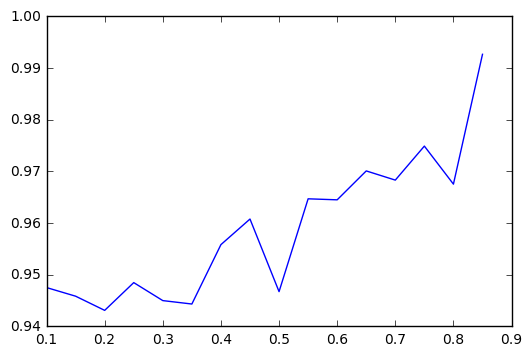

In [37]:
plt.plot(np.arange(0.1, 0.9, 0.05), mis_err)
#np.sum((Ypred == 1) * (Ymask == 0))/np.sum(Ymask == 0)
plt.savefig("FNR.png", dpi = 300, bbox_inches ="tight")

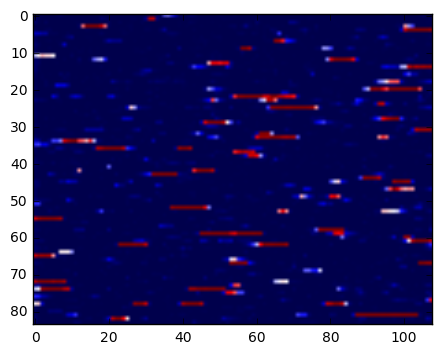

In [17]:
missing_rate = 0.2
mask = stats.bernoulli.rvs(missing_rate, size = Y.shape)
Ymask = Y * mask
Ytrue = Y * (1 - mask)
ans = Gibbs_GCHMM(G, Ytrue, mask, T = 500)
plt.imshow(ans[0], cmap='seismic')
plt.savefig("missing02.png", dpi = 300, bbox_inches ="tight")

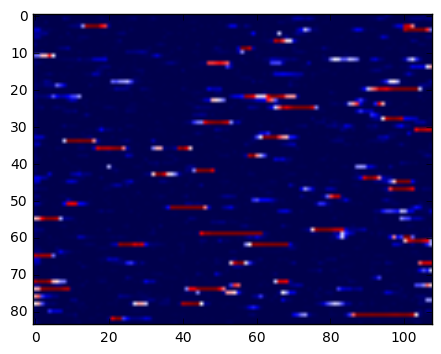

In [19]:
missing_rate = 0.4
mask = stats.bernoulli.rvs(missing_rate, size = Y.shape)
Ymask = Y * mask
Ytrue = Y * (1 - mask)
ans = Gibbs_GCHMM(G, Ytrue, mask, T = 500)
plt.imshow(ans[0], cmap='seismic')
plt.savefig("missing04.png", dpi = 300, bbox_inches ="tight")

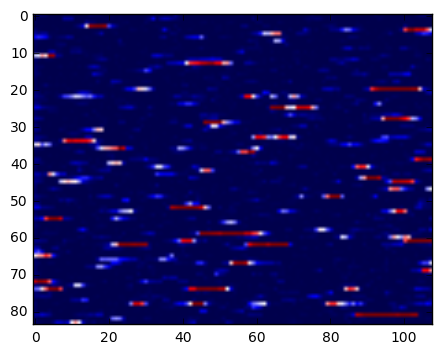

In [21]:
missing_rate = 0.6
mask = stats.bernoulli.rvs(missing_rate, size = Y.shape)
Ymask = Y * mask
Ytrue = Y * (1 - mask)
ans = Gibbs_GCHMM(G, Ytrue, mask, T = 500)
plt.imshow(ans[0], cmap='seismic')
plt.savefig("missing06.png", dpi = 300, bbox_inches ="tight")

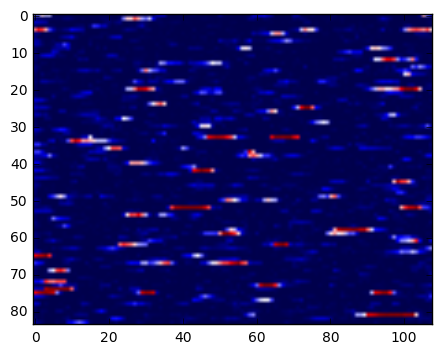

In [22]:
missing_rate = 0.8
mask = stats.bernoulli.rvs(missing_rate, size = Y.shape)
Ymask = Y * mask
Ytrue = Y * (1 - mask)
ans = Gibbs_GCHMM(G, Ytrue, mask, T = 500)
plt.imshow(ans[0], cmap='seismic')
plt.savefig("missing08.png", dpi = 300, bbox_inches ="tight")

In [10]:
missing_rate = 0
mask = stats.bernoulli.rvs(missing_rate, size = Y.shape)
Ymask = Y * mask
Ytrue = Y * (1 - mask)

In [12]:
ans = Gibbs_GCHMM(G, Ytrue, mask, T = 500)

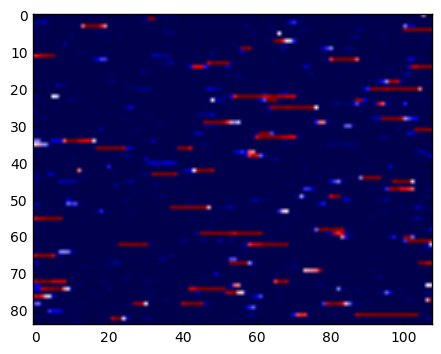

In [13]:
plt.imshow(ans[0], cmap='seismic')
plt.savefig("predicted.png", dpi = 300, bbox_inches ="tight")

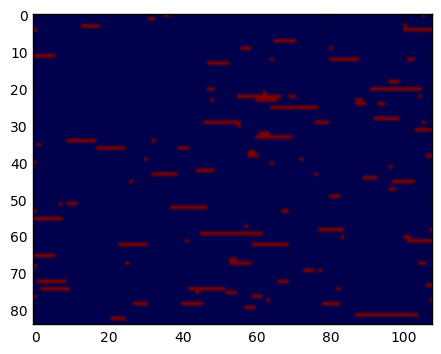

In [14]:
plt.imshow(X, cmap='seismic')
plt.savefig("true.png", dpi = 300, bbox_inches ="tight")

In [17]:
def work_whole(G, Y, T = 500):
    Gibbs_GCHMM(G, Y, T = 500)

In [18]:
%prun -q -D Gibbs_GCHMM.prof Gibbs_GCHMM(G, Y, T = 500)

 
*** Profile stats marshalled to file 'Gibbs_GCHMM.prof'. 


In [19]:
p = pstats.Stats('Gibbs_GCHMM.prof')
p.sort_stats('time', 'cumulative').print_stats(10)
pass

Mon May  1 13:31:29 2017    Gibbs_GCHMM.prof

         524722 function calls in 10.767 seconds

   Ordered by: internal time, cumulative time
   List reduced from 63 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    6.268    6.268   10.767   10.767 <ipython-input-14-54eb1aa86164>:1(Gibbs_GCHMM)
   107000    3.104    0.000    3.104    0.000 <ipython-input-14-54eb1aa86164>:83(NumPreInf)
    13512    0.515    0.000    0.515    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    54500    0.259    0.000    0.259    0.000 {method 'rand' of 'mtrand.RandomState' objects}
      500    0.116    0.000    0.116    0.000 {method 'repeat' of 'numpy.ndarray' objects}
   110004    0.095    0.000    0.095    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     3006    0.045    0.000    0.363    0.000 /opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:909(rvs)
    35295    0.035    0.000    0.035    0.000 {bu